In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle

import torch
import torch.nn.functional as F

In [2]:
with uproot.open("../pythia/output/dataset_4b_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    trk_pt = f["trk_jet_pT"].array()
    trk_eta = f["trk_jet_eta"].array()
    trk_phi = f["trk_jet_phi"].array()
    trk_q = f["trk_jet_q"].array()
    trk_d0 = f["trk_jet_d0"].array()
    trk_z0 = f["trk_jet_z0"].array()
    trk_label = f["trk_jet_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()
    jet_pufr_truth = f["jet_pufr_truth"].array()

In [3]:
%%time
#jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_corrJVF,jet_RpT,jet_pufr_truth]
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_pufr_truth]

jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)

print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

Num Events:  10000
Num Jets in first event:  179
Num Jet Features:  5
CPU times: user 68.8 ms, sys: 1.13 ms, total: 70 ms
Wall time: 69.2 ms


In [4]:
%%time
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_label]
trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=3)

print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Num Events:  10000
Num Jets in first event:  179
Num Tracks in first event first jet:  125
Num Tracks features:  7
CPU times: user 7.04 s, sys: 15 s, total: 22 s
Wall time: 22 s


In [5]:
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

trk_q_cut = selected_tracks[:,:,:,3]!=0            # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4.5    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4          # 400MeV Cut

mask = trk_q_cut & trk_eta_cut & trk_pt_cut

selected_tracks = selected_tracks[mask]

In [6]:
# Skip trackless jets!
trackless_jets_mask = (ak.num(selected_tracks, axis=2)!=0)
selected_jets = selected_jets[trackless_jets_mask]
selected_tracks = selected_tracks[trackless_jets_mask]

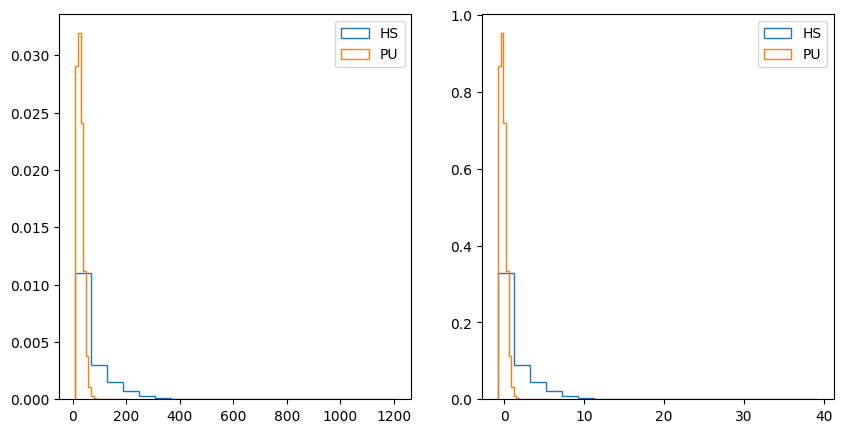

Mean Before:  32.88435425373041 		 Mean After:  9.612320783025745e-05
STD Before:  29.831415133891337 		 STD After:  0.9999212093591016


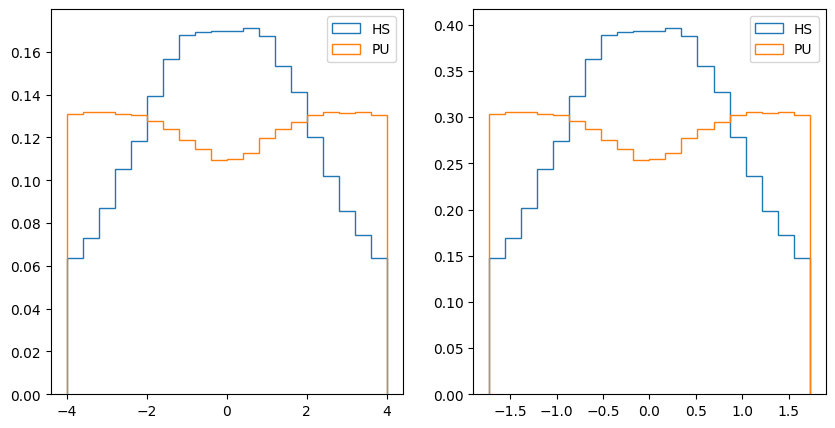

Mean Before:  -0.0008344983053228526 		 Mean After:  -1.1834636434956704e-08
STD Before:  2.317119419912815 		 STD After:  1.0001643475168907


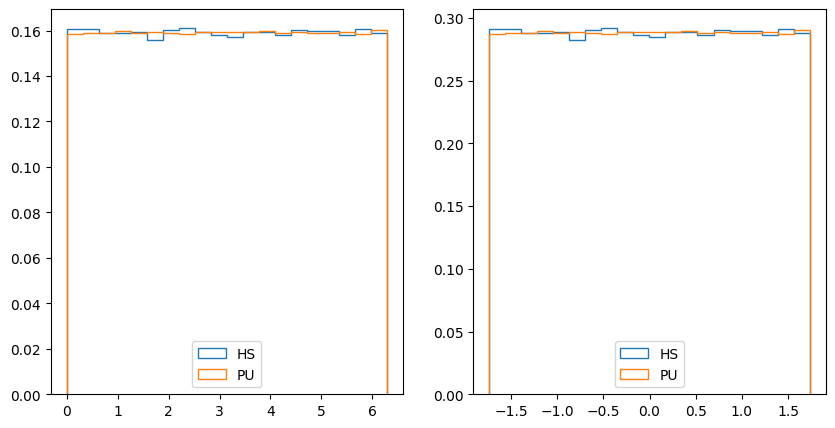

Mean Before:  3.142401042978958 		 Mean After:  3.0073817471651292e-05
STD Before:  1.812466315938268 		 STD After:  1.0007500302606047


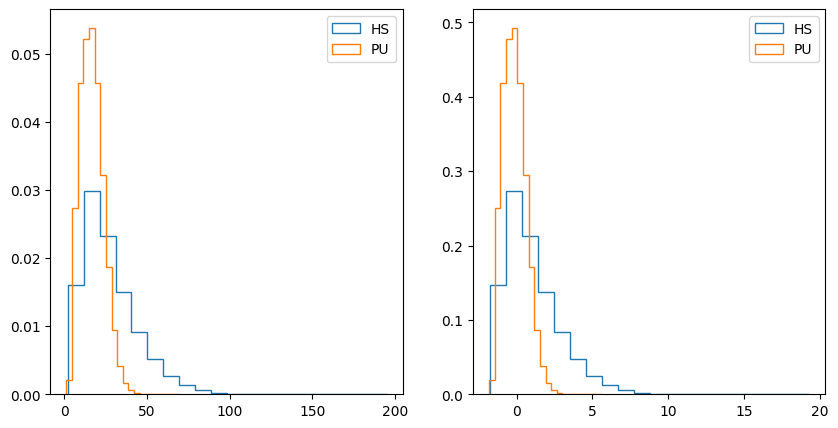

Mean Before:  17.90111586391847 		 Mean After:  2.083478713664192e-05
STD Before:  9.160679632880875 		 STD After:  0.9998271103505596


In [7]:
num_jet_feats = len(selected_jets[0][0])-1

sig = selected_jets[:,:,-1]<0.7
bkg = ~sig

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
# Append Labels
norm_list.append(selected_jets[:,:,-1])

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

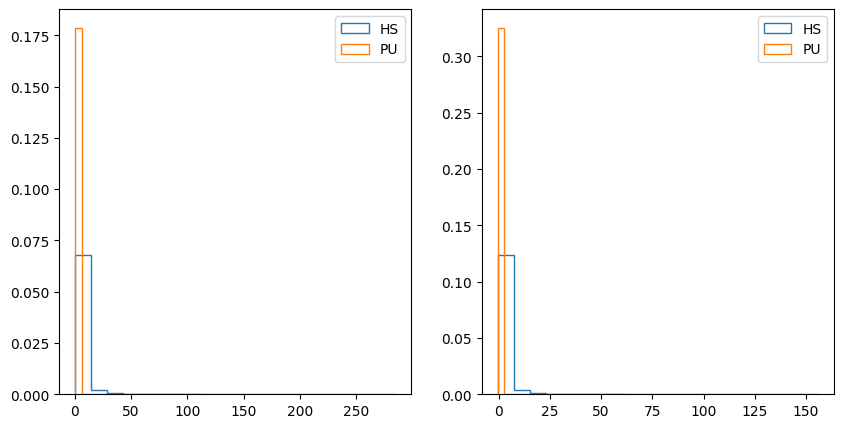

Mean Before:  1.0408053935578383 		 Mean After:  -5.092391005291301e-17
STD Before:  1.8204892325945004 		 STD After:  0.9999999999994938


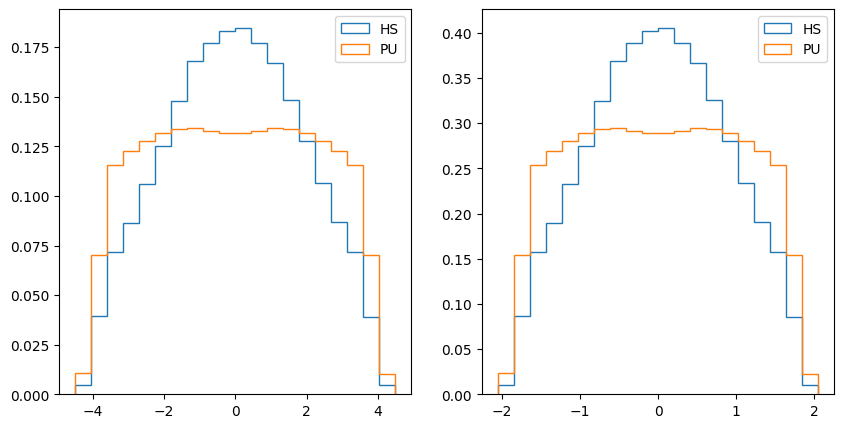

Mean Before:  -0.0007099750909327457 		 Mean After:  1.4161385509751374e-17
STD Before:  2.1949131560727895 		 STD After:  0.9999999999995051


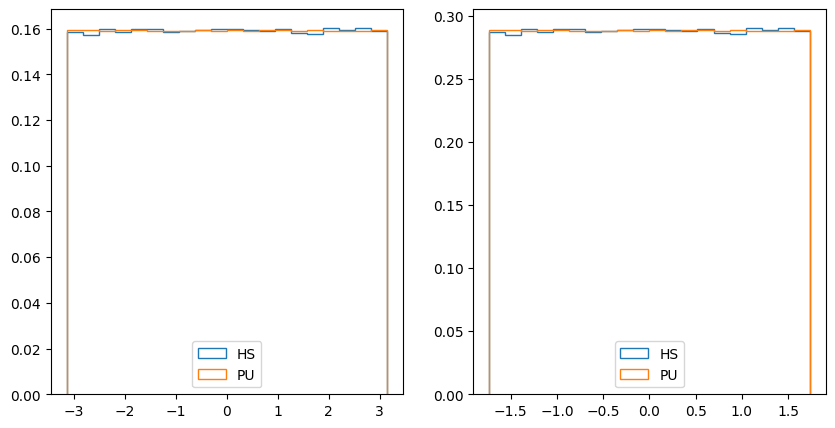

Mean Before:  -0.00021649400818007683 		 Mean After:  8.863719488872469e-18
STD Before:  1.813620800661735 		 STD After:  0.9999999999994824


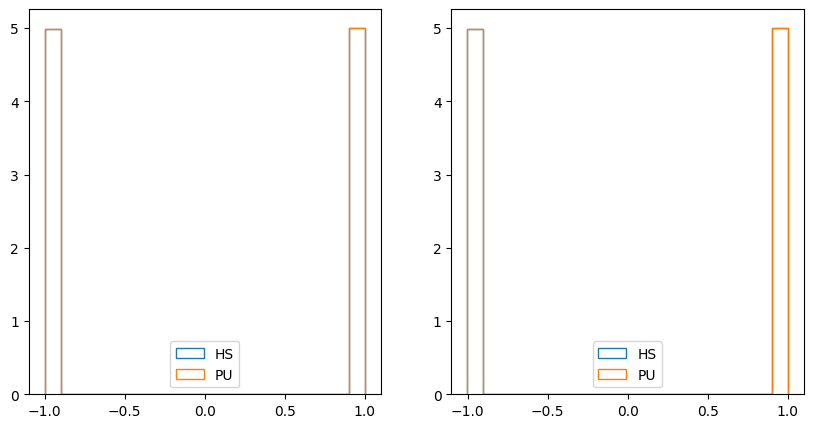

Mean Before:  0.0015001825489149795 		 Mean After:  1.2310391440464302e-14
STD Before:  0.9999988747255268 		 STD After:  0.9999999999992244


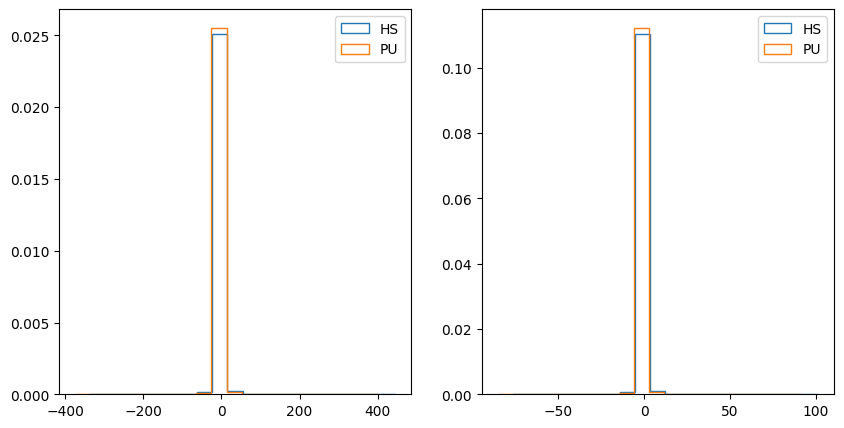

Mean Before:  -5.024940817002001e-05 		 Mean After:  -1.3312176019796753e-17
STD Before:  4.393978717560758 		 STD After:  0.9999999999999827


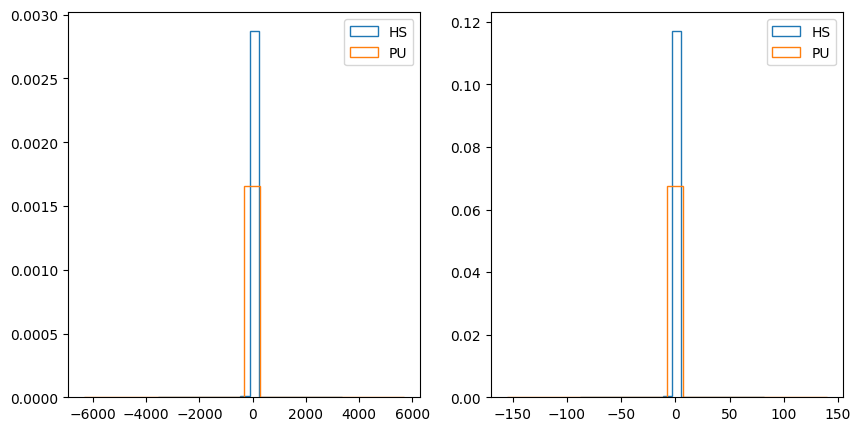

Mean Before:  0.0021741299092059314 		 Mean After:  -1.3894793536943074e-17
STD Before:  40.76402529248673 		 STD After:  0.9999999999999204


In [8]:
num_trk_feats = len(selected_tracks[0][0][0])-1

sig = selected_tracks[:,:,:,-1]==-1
bkg = ~sig

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax1.legend()
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,density=True)
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))
norm_list.append(selected_tracks[:,:,:,-1])
    
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [9]:
all_tracks = ak.flatten(selected_tracks, axis=2)

print("Jet Shape:\t", selected_jets.type)
print("Trk_Jet  Shape:\t", selected_tracks.type)
print("Trk_All Shape:\t", all_tracks.type)

Jet Shape:	 10000 * var * 5 * float64
Trk_Jet  Shape:	 10000 * var * var * 7 * float64
Trk_All Shape:	 10000 * var * 7 * float64


In [10]:
%%time
# Generate List of torch tensors on event by event basis
# Pad number of tracks per jet 

num_events = len(selected_jets)

Event_Data = []
Event_Labels = []

for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)

    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])        
        pad = (0,0,0,max_num_trks-len(tracks))        
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    
    # Append all data but don't include label 0:-1!
    flat_tracks = torch.Tensor(all_tracks[event][:,0:-1])
    Event_Data.append((jets[:,0:-1],tracks[:,:,0:-1],flat_tracks))
    #Event_Labels.append((jets[:,-1].reshape(-1,1),tracks[:,:,-1].reshape(-1,1)))
    Event_Labels.append(jets[:,-1].reshape(-1,1))

print("Processing: ", num_events, " / ", num_events)

Processing:  10000  /  10000
CPU times: user 12min 35s, sys: 788 ms, total: 12min 36s
Wall time: 12min 35s


In [11]:
train_split = int(0.7*num_events)  # 70% train
test_split = int(0.75*num_events)  #  5% val + 25% test

Event_List = list(zip(Event_Data, Event_Labels))

Events_training = Event_List[0:train_split]
Events_validation = Event_List[train_split:test_split]
Events_testing = Event_List[test_split:]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

Processing:  10000  /  10000
Training Events:  7000
Validation Events:  500
Testing Events:  2500


In [12]:
#data = (Event_List,Event_Labels)
#pickle.dump(data, open("data_4b.pkl", "wb"))

In [13]:
#raise Exception("Stop!")

In [14]:
X_train, y_train = list(zip(*Events_training))
X_val, y_val = list(zip(*Events_validation))
X_test, y_test = list(zip(*Events_testing))

data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle.dump(data, open("datasets/data_4b.pkl", "wb"))

In [15]:
print("X_train Indices Reference:")
print("\tNum Events: ", len(X_train))
print("\tNum Tensors: ", len(X_train[0]), "(Jet, trk-jet, flat trk)")
print("\tNum Jets: ", len(X_train[0][0]))
print("\tNum Trks per Jet: ", len(X_train[0][1][0]))
print("\tNum Flat Trks: ", len(X_train[0][2]))
print("\tNum Jet Feats: ", len(X_train[0][0][0]))
print("\tNum Trk Feats: ", len(X_train[0][1][0][0]))
print()
print("y_train Indices Reference:")
print("\tNum Events: ", len(y_train))
print("\tNum Jets: ", len(y_train[0]))

X_train Indices Reference:
	Num Events:  7000
	Num Tensors:  3 (Jet, trk-jet, flat trk)
	Num Jets:  108
	Num Trks per Jet:  41
	Num Flat Trks:  2037
	Num Jet Feats:  4
	Num Trk Feats:  6

y_train Indices Reference:
	Num Events:  7000
	Num Jets:  108


In [16]:
# Shuffle
# Split train, val, test
# Calc train mean and std
# Norm train, val, test
# Split batches
# Pad jets and tracks in batches

In [17]:
"""
# Shuffle and pad the tracks and jets
num_events = len(selected_jets)

for event in range(1):
    num_jets = len(selected_jets[event])
    num_trks = ak.num(refined_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    print(max_num_trks)
    
    
    for jet in range(num_jets):
        p = np.random.permutation(len(refined_tracks[event][jet]))
        tmp = refined_tracks[event][jet][p]
        #print(tmp.show())
        tmp = ak.pad_none(tmp,max_num_trks,axis=0)
        tmp = ak.pad_none(tmp,7,axis=1)
        tmp = ak.fill_none(tmp, 0)
        print(jet)
        print(tmp.show())

    p = np.random.permutation(len(selected_jets[event]))
    tmp = selected_jets[event][p]
    tmp = refined_tracks[event][p]
    
# Pad num tracks per jet on event basis
num_events = len(selected_jets)
print(num_events)
for event in range(1):
    len_list = []
    num_jets = len(selected_jets[event])
    num_trks = ak.num(refined_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)
    print(max_num_trks)
    
    print(refined_tracks[event].show)
    pad = ak.pad_none(refined_tracks[event], max_num_trks, axis=1).to_list()
    print(pad[1][-1])
    pad2 = ak.fill_none(pad,0).to_list()
    #print(pad2)
    print(pad2[1][-1])

    pad = ak.pad_none(pad, 7, axis=1)
    print(pad)
    print(pad[-1])
    tmp = ak.pad_none(pad,7,axis=1)
    print(pad)
    print(pad[-1])
"""

'\n# Shuffle and pad the tracks and jets\nnum_events = len(selected_jets)\n\nfor event in range(1):\n    num_jets = len(selected_jets[event])\n    num_trks = ak.num(refined_tracks[event], axis=1)\n    max_num_trks = ak.max(num_trks)\n    print(max_num_trks)\n    \n    \n    for jet in range(num_jets):\n        p = np.random.permutation(len(refined_tracks[event][jet]))\n        tmp = refined_tracks[event][jet][p]\n        #print(tmp.show())\n        tmp = ak.pad_none(tmp,max_num_trks,axis=0)\n        tmp = ak.pad_none(tmp,7,axis=1)\n        tmp = ak.fill_none(tmp, 0)\n        print(jet)\n        print(tmp.show())\n\n    p = np.random.permutation(len(selected_jets[event]))\n    tmp = selected_jets[event][p]\n    tmp = refined_tracks[event][p]\n    \n# Pad num tracks per jet on event basis\nnum_events = len(selected_jets)\nprint(num_events)\nfor event in range(1):\n    len_list = []\n    num_jets = len(selected_jets[event])\n    num_trks = ak.num(refined_tracks[event], axis=1)\n    max_nu